# 2. CNNs en Google Street View 

** 2.0 Importación de módulos necesarios **

In [1]:
import scipy.io as sio
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adadelta, Adagrad, Adam
from keras import backend
from sklearn.metrics import confusion_matrix
import math
import random
import matplotlib.pyplot as plt

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce 820M (CNMeM is disabled, cuDNN not available)


**2.1 Construcción de conjuntos de datos**

A partir de los archivos disponibles en formato Matlab, se construyen los conjuntos de entrenamiento y de prueba, separando los atributos predictores del atributo a predecir en primer lugar, para luego almacenarlos en matrices.

In [2]:
# Se cargan datos de entrenamiento
train_data = sio.loadmat('train_32x32.mat')
# Se cargan datos de prueba
test_data = sio.loadmat('test_32x32.mat')

# Se crea conjunto de entrenamiento con atributos predictores
X_train = train_data['X'].T.astype('float32')
# Se crea conjunto de entrenamiento con atributo a predecir
y_train = train_data['y'] - 1

# Se crea conjunto de prueba con atributos predictores
X_test = test_data['X'].T.astype('float32')
# Se crea conjunto de prueba con atributo a predecir
y_test = test_data['y'] - 1

A continuación, se determinan las dimensiones de las imágenes.

In [3]:
# Se determinan dimensiones y cantidad de ejemplos en conjunto de entrenamiento
n_channels = X_train.shape[1]
n_rows = X_train.shape[2]
n_cols = X_train.shape[3]
X_train.shape

(73257, 3, 32, 32)

In [4]:
# Se determinan dimensiones y cantidad de ejemplos en conjunto de prueba
X_test.shape

(26032, 3, 32, 32)

Los comandos anteriores muestran que se está trabajando con imágenes de 3 canales de 32 x 32. Además, el conjunto de entrenamiento está constituído por 73.257 ejemplos, mientras que el conjunto de pruebas está integrado por 26.032 ejemplos.

Por otra parte, el siguiente comando permite determinar la cantidad de clases diferentes que existen en el problema.

In [5]:
# Se obtiene número de clases del problema
n_classes = len(np.unique(y_train))
print n_classes

10


Esto es, existen 10 clases diferentes en el problema, cada una asociada a un dígito.

Además, se muestra la cantidad de ejemplos existentes por categoría para cada uno de los conjuntos de datos.

In [6]:
print 'Cantidad de ejemplos por categoría en conjunto de entrenamiento\n'
for i in range(n_classes):
    print 'Dígito', i, ':', len(np.where(y_train == i)[0]), 'ejemplos'

print('\n')
    
print 'Cantidad de ejemplos por categoría en conjunto de pruebas\n'
for i in range(n_classes):
    print 'Dígito', i, ':', len(np.where(y_test == i)[0]), 'ejemplos'

Cantidad de ejemplos por categoría en conjunto de entrenamiento

Dígito 0 : 13861 ejemplos
Dígito 1 : 10585 ejemplos
Dígito 2 : 8497 ejemplos
Dígito 3 : 7458 ejemplos
Dígito 4 : 6882 ejemplos
Dígito 5 : 5727 ejemplos
Dígito 6 : 5595 ejemplos
Dígito 7 : 5045 ejemplos
Dígito 8 : 4659 ejemplos
Dígito 9 : 4948 ejemplos


Cantidad de ejemplos por categoría en conjunto de pruebas

Dígito 0 : 5099 ejemplos
Dígito 1 : 4149 ejemplos
Dígito 2 : 2882 ejemplos
Dígito 3 : 2523 ejemplos
Dígito 4 : 2384 ejemplos
Dígito 5 : 1977 ejemplos
Dígito 6 : 2019 ejemplos
Dígito 7 : 1660 ejemplos
Dígito 8 : 1595 ejemplos
Dígito 9 : 1744 ejemplos


Finalmente, se visualizan 10 imágenes: 5 del conjunto de entrenamiento y 5 del conjunto de pruebas, elegidas de forma totalmente aleatoria.

Imágenes conjunto de entrenamiento


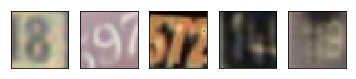

Imágenes conjunto de prueba


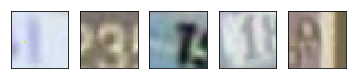

In [7]:
print "Imágenes conjunto de entrenamiento"

# Se seleccionan 5 imágenes de forma aleatoria a partir del conjunto de entrenamiento
train_images = random.sample(X_train, 5)

# Se grafican imágenes
for i in range(0, len(train_images)):      
    ax = plt.subplot(2, 5, 1 + i)
    im = train_images[i].reshape(3 ,32, 32).transpose(2, 1, 0)
    plt.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
plt.show()

print "Imágenes conjunto de prueba"

# Se seleccionan 5 imágenes de forma aleatoria a partir del conjunto de prueba
test_images = random.sample(X_test, 5)

# Se grafican imágenes
for i in range(0, len(test_images)):      
    ax = plt.subplot(2, 5, 1 + i)
    im = test_images[i].reshape(3 ,32, 32).transpose(2, 1, 0)
    plt.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
plt.show()

** 2.2 Normalización de datos **

Ya construídos los conjuntos de datos necesarios, se procede a normalizar las imágenes, para lo cual se dividen las intensidades de pixel de cada uno de dichos conjuntos por 255, que corresponde al máximo valor posible que un pixel puede tener. De esta manera, cada imágen será manejada computacionalmente como una matriz de números entre 0 y 1.

In [8]:
# Se dividen las intensidades de pixel por la intensidad máxima en ambos conjuntos de datos
X_train /= 255.
X_test /= 255.

Además, los vectores que almacenan las clases del problema son transformados en matrices categóricas con el fin de poder computar el error asociado a cada ejemplo en cada unas de las fases del proceso de entrenamiento.

In [9]:
# Vectores que contienen atributos a predecir son transformados en matrices categóricas
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

En este punto, también es conveniente generar un conjunto de validación para la comparación de diferentes arquitecturas en las siguientes secciones. Para esto, se extraerá aproximádamente el 20% final de los registros (14.651 registros) del conjunto de entrenamiento para construir el conjunto de validación, quedando el 80% restante como conjunto de entrenamiento (58.606 registros).

In [10]:
# Se construye conjunto de validación y posteriormente se reestructura conjunto de entrenamiento
X_val = X_train[int(math.ceil(0.8 * X_train.shape[0])) : , :, :, :]
Y_val = Y_train[int(math.ceil(0.8 * Y_train.shape[0])) :]
X_train = X_train[: int(math.ceil(0.8 * X_train.shape[0])), :, :, :]
Y_train = Y_train[: int(math.ceil(0.8 * Y_train.shape[0])), :]

** 2.3 Construcción de modelo clasificador **

En esta sección, se construye un modelo clasificador por medio del entrenamiento de una red convolucional. Su arquitectura base es *C* X *P* X *C* X *P* X *F* X *F*. Las capas de la red poseen las características que se detallan a continuación:

- La primera capa convolucional utiliza 16 filtros de dimensiones 5 x 5.
- La segunda capa convolucional utiliza 512 filtros de dimensiones 7 x 7.
- Ambas capas convolucionales son de tipo 2D.
- Entre cada una de las capas convolucionales se sitúa una capa de tipo max pooling (capa de reducción), las que escalan las dimensiones del input recibido en un factor de 2.
- La capa densa está compuesta por 20 neuronas.
- Entre la última capa de reducción y la capa densa se sitúa una capa de tipo flatten para la generación del vector de características a ser procesado por la capa densa.
- Tanto en las capas convolucionales como en la capa densa se utiliza la función de activación relu. 
- La capa de salida posee 10 neuronas y en ella se aplica la función de activación softmax.

El código utilizado para implementar la red previamente descrita es mostrado a continuación:

In [25]:
# Definición de arquitectura convolucional
# Se crea modelo vacío
original_model = Sequential()
# Se añade primera capa convolucional
original_model.add(Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=(n_rows, n_cols, n_channels)))
# Se agrega primera capa de reducción
original_model.add(MaxPooling2D(pool_size=(2,2)))
# Se introduce segunda capa convolucional
original_model.add(Conv2D(512, (7, 7), padding='same', activation='relu'))
# Se añade segunda capa de reducción
original_model.add(MaxPooling2D(pool_size=(2,2)))
# Se agrega capa de tipo flatten
original_model.add(Flatten())
# Se introduce capa densa
original_model.add(Dense(20, activation='relu'))
# Se añade capa de salida
original_model.add(Dense(n_classes, activation='softmax'))

Ya definido el modelo con que se trabajará, es interesante observar como las dimensiones de un input determinado cambian a medida que este es procesado por cada una de las capas de la red. A continuación, se muestra una tabla resumen en la que, por cada capa, se específican las dimensiones del output producido y así como la cantidad de parámetros que el modelo posee.

In [26]:
# Se obtiene información acerca del modelo definido
original_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 16)        1216      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 512)       401920    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                655380    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
Total para

Se sabe que, en este problema, los inputs originales poseen dimensiones (número de filas de la imágen, número de columnas de la imágen, número de canales de la imágen). Específicamente, cada imágen del dataset con que se está trabajando posee dimensiones (32, 32, 3). Luego, se tiene, por ejemplo, que después de ser procesadas por la primera capa convolucional, las imágenes aumentan su número de canales de 3 a 16. Por otro lado, la primera capa de reducción reduce a la mitad tanto el número de filas como de columnas de la imágen, manteniendo el número de canales anterior. Otro caso notable es lo que ocurre con la capa de tipo flatten, la que se encarga de "destruir" la estructura tridimensional de la imágen, convirtiendo a cada una de ellas en un vector de tamaño número de filas x número de columnas x número de canales, con el fin de que puedan ser procesadas de forma adecuada por la capa densa. Se observa, además, que el modelo posee un total de 1.058.726 parámetros.

Ahora, se procede a entrenar el modelo previamente definido. Considerando que se está tratando un problema donde las clases son mutuamente excluyentes y además existen más de 2 clases, lo más apropiado es usar la función de pérdida *categorical crossentropy*. Se utilizará el método de entrenamiento *adagrad*, con el fin de adaptar la tasa de aprendizaje en cada iteración de entrenamiento. Se usará una tasa de aprendizaje inicial de 1e-08, batches de tamaño 256 y 10 epochs.

In [11]:
# Dada la actualización de la API de Keras, es necesario redimensionar las imágenes
X_train_ = X_train.reshape((X_train.shape[0], n_rows, n_cols, n_channels))
X_val_ = X_val.reshape((X_val.shape[0], n_rows, n_cols, n_channels))
X_test_ = X_test.reshape((X_test.shape[0], n_rows, n_cols, n_channels))

In [27]:
# Se definen la función de pérdida a utilizar y el método de entrenamiento
original_model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
# Se entrena modelo
original_model.fit(X_train_, Y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val_, Y_val))

Train on 58606 samples, validate on 14651 samples
Epoch 1/10
58606/58606 [==============================] - 696s - loss: 3.2568 - acc: 0.1985 - val_loss: 1.9895 - val_acc: 0.2935
Epoch 2/10
58606/58606 [==============================] - 700s - loss: 1.8473 - acc: 0.3762 - val_loss: 1.5891 - val_acc: 0.4971
Epoch 3/10
58606/58606 [==============================] - 703s - loss: 1.3835 - acc: 0.5586 - val_loss: 1.2727 - val_acc: 0.5855
Epoch 4/10
58606/58606 [==============================] - 706s - loss: 1.0142 - acc: 0.6911 - val_loss: 0.9205 - val_acc: 0.7206
Epoch 5/10
58606/58606 [==============================] - 713s - loss: 0.8318 - acc: 0.7519 - val_loss: 0.7897 - val_acc: 0.7627
Epoch 6/10
58606/58606 [==============================] - 710s - loss: 0.7326 - acc: 0.7827 - val_loss: 0.7167 - val_acc: 0.7878
Epoch 7/10
58606/58606 [==============================] - 717s - loss: 0.6736 - acc: 0.8018 - val_loss: 0.6889 - val_acc: 0.7910
Epoch 8/10
58606/58606 [=======================

Se observa que la precisión de entrenamiento alcanzada es un de 83,55%, mientras que la de validación es de un 82,38%. Además, el tiempo total de entrenamiento fue de 7095 [s] . Finalmente, se evalúa el modelo construído sobre el conjunto de prueba.

In [29]:
original_model_scores = original_model.evaluate(X_test_, Y_test)
print '\nPrecision sobre conjunto de pruebas:', original_model_scores[1] * 100, '%'

26016/26032 [============================>.] - ETA: 0s
Precision sobre conjunto de pruebas: 82.8326674862 %


Luego, se obtiene una precisión de prueba del 82,83%, inferior a la precisión *state-of-the-art*, que es de un 94,28%.

**2.4 Modificando el tamaño de los filtros**

En esta sección, se evalúan los efectos de modificar tanto el tamaño de los filtros utilizados en las capas convolucionales como el factor de reducción de las capas de tipo pooling. Especificamente, se desea saber como tales modificaciones benefician o bien perjudican la precisión obtenida sobre el conjunto de pruebas.   

**2.4.1 Primer caso: Filtros de 7 x 7, pooling de 4 x 4**

En primer lugar, se experimentará utilizando filtros de tamaño 7 x 7 en cada capa convolucional, por lo que, en la primera de estas, el tamaño de los filtros se mantiene, mientras que en la segunda, se reduce en dos unidades. También, el factor de reducción presente en las capas de pooling será disminuído a 4, esto es, los inputs recibidos por estas capas serán reducidos a la cuarta parte en cada dimensión.

In [12]:
model_7x4 = Sequential()
# Se añade primera capa convolucional, con filtros de tamaño 7 x 7
model_7x4.add(Conv2D(16, (7, 7), padding='same', activation='relu', input_shape=(n_rows, n_cols, n_channels)))
# Se agrega primera capa de reducción, reduciendo factor de pooling a 4 en cada dimensión
model_7x4.add(MaxPooling2D(pool_size=(4, 4)))
# Se introduce segunda capa convolucional, idéntica a la anterior
model_7x4.add(Conv2D(512, (7, 7), padding='same', activation='relu'))
# Se añade segunda capa de reducción, idéntica a la anterior
model_7x4.add(MaxPooling2D(pool_size=(4, 4)))
# Se agrega capa de tipo flatten
model_7x4.add(Flatten())
# Se introduce capa densa
model_7x4.add(Dense(20, activation='relu'))
# Se añade capa de salida
model_7x4.add(Dense(n_classes, activation='softmax'))

Ya definido este nuevo modelo, se procede a entrenarlo.

In [14]:
# Se definen la función de pérdida a utilizar y el método de entrenamiento
model_7x4.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
# Se entrena modelo
model_7x4_history = model_7x4.fit(X_train_, Y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val_, Y_val))
model_7x4.save('model_7x4.h5')

Train on 58606 samples, validate on 14651 samples
Epoch 1/10
58606/58606 [==============================] - 539s - loss: 1.7743 - acc: 0.3670 - val_loss: 1.6662 - val_acc: 0.3993
Epoch 2/10
58606/58606 [==============================] - 278s - loss: 1.6233 - acc: 0.4105 - val_loss: 1.5700 - val_acc: 0.4516
Epoch 3/10
58606/58606 [==============================] - 282s - loss: 1.5124 - acc: 0.4686 - val_loss: 1.4591 - val_acc: 0.4985
Epoch 4/10
58606/58606 [==============================] - 280s - loss: 1.4028 - acc: 0.5253 - val_loss: 1.3809 - val_acc: 0.5173
Epoch 5/10
58606/58606 [==============================] - 281s - loss: 1.3254 - acc: 0.5526 - val_loss: 1.3160 - val_acc: 0.5642
Epoch 6/10
58606/58606 [==============================] - 281s - loss: 1.2753 - acc: 0.5683 - val_loss: 1.3032 - val_acc: 0.5498
Epoch 7/10
58606/58606 [==============================] - 281s - loss: 1.2339 - acc: 0.5807 - val_loss: 1.2385 - val_acc: 0.5826
Epoch 8/10
58606/58606 [=======================

Luego, se evalúa el modelo sobre el conjunto de pruebas.

In [27]:
model_7x4_scores = model_7x4.evaluate(X_test_, Y_test)
print '\nPrecision sobre conjunto de pruebas:', model_7x4_scores[1] * 100, '%'

26016/26032 [============================>.] - ETA: 0s
Precision sobre conjunto de pruebas: 60.8750768285 %


Se observa se obtiene una precisión del 60,88% sobre el conjunto de prueba, siendo bastante menor a la precisión obtenida por la arquitectura definida originalmente. Sin embargo, el tiempo de entrenamiento fue de 3065 [s], considerablemente menor que el de la primera arquitectura.

**2.4.2 Segundo caso: Filtros de 5 x 5, pooling de 4 x 4**

Ahora, se estudiará el efecto de duplicar el factor de reducción utilizado en la sección anterior, esto es, usando un *pool size* de 4 x 4 en cada capa de pooling. Además, el tamaño de los filtros se mantendrá en 5 x 5 para cada capa convolucional.

In [16]:
model_5x4 = Sequential()
# Se añade primera capa convolucional, manteniendo constante el tamaño de los filtros
model_5x4.add(Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=(n_rows, n_cols, n_channels)))
# Se agrega primera capa de reducción, aumentando factor de pooling a 4 en cada dimensión
model_5x4.add(MaxPooling2D(pool_size=(4, 4)))
# Se introduce segunda capa convolucional, idéntica a la anterior
model_5x4.add(Conv2D(512, (5, 5), padding='same', activation='relu'))
# Se añade segunda capa de reducción, idéntica a la anterior
model_5x4.add(MaxPooling2D(pool_size=(4, 4)))
# Se agrega capa de tipo flatten
model_5x4.add(Flatten())
# Se introduce capa densa
model_5x4.add(Dense(20, activation='relu'))
# Se añade capa de salida
model_5x4.add(Dense(n_classes, activation='softmax'))

Así, se procede a entrenar este modelo.

In [17]:
model_5x4.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
model_5x4_history = model_5x4.fit(X_train_, Y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val_, Y_val))
model_5x4.save('model_5x4.h5')

Train on 58606 samples, validate on 14651 samples
Epoch 1/10
58606/58606 [==============================] - 201s - loss: 2.2877 - acc: 0.1882 - val_loss: 2.1658 - val_acc: 0.2012
Epoch 2/10
58606/58606 [==============================] - 201s - loss: 2.0400 - acc: 0.2880 - val_loss: 1.8433 - val_acc: 0.4224
Epoch 3/10
58606/58606 [==============================] - 201s - loss: 1.6642 - acc: 0.4585 - val_loss: 1.5436 - val_acc: 0.4696
Epoch 4/10
58606/58606 [==============================] - 201s - loss: 1.3954 - acc: 0.5479 - val_loss: 1.2989 - val_acc: 0.5793
Epoch 5/10
58606/58606 [==============================] - 201s - loss: 1.2325 - acc: 0.6047 - val_loss: 1.2477 - val_acc: 0.5934
Epoch 6/10
58606/58606 [==============================] - 201s - loss: 1.1280 - acc: 0.6396 - val_loss: 1.0798 - val_acc: 0.6683
Epoch 7/10
58606/58606 [==============================] - 201s - loss: 1.0496 - acc: 0.6674 - val_loss: 1.1099 - val_acc: 0.6314
Epoch 8/10
58606/58606 [=======================

Ya entrenado el modelo, este es evaluado sobre el conjunto de pruebas.

In [18]:
model_5x4_scores = model_5x4.evaluate(X_test_, Y_test)
print 'Precision sobre conjunto de pruebas:', model_5x4_scores[1] * 100, '%'

26032/26032 [==============================] - 17s    
Precision sobre conjunto de pruebas: 74.0626920713 %


En consecuencia, la nueva precisión de prueba que se obtiene es de un 74,06%, empeorando respecto a la arquitectura original, pero aumentando respecto a la precisión obtenida en la sección 2.4.1. Por otro lado, el tiempo total de entrenamiento fue de 2010 [s], el menor de todos hasta ahora.

**2.4.3 Tercer caso: Filtros de 9 x 9, pooling de 2 x 2**

En esta subsección, se analizará el efecto de aumentar considerablemente el tamaño de los filtros utilizados en las capas convolucionales, siendo sus tamaños de 9 x 9. Además, el factor de reducción en las capas de pooling se reducirá nuevamente a 2 x 2.

In [19]:
model_9x2 = Sequential()
# Se añade primera capa convolucional, aumentando tamaño de los filtros a 9 en cada dimensión
model_9x2.add(Conv2D(16, (9, 9), padding='same', activation='relu', input_shape=(n_rows, n_cols, n_channels)))
# Se agrega primera capa de reducción, reduciendo el factor de pooling a 2 en cada dimensión
model_9x2.add(MaxPooling2D(pool_size=(2, 2)))
# Se introduce segunda capa convolucional, idéntica a la anterior
model_9x2.add(Conv2D(512, (9, 9), padding='same', activation='relu'))
# Se añade segunda capa de reducción, idéntica a la anterior
model_9x2.add(MaxPooling2D(pool_size=(2, 2)))
# Se agrega capa de tipo flatten
model_9x2.add(Flatten())
# Se introduce capa densa
model_9x2.add(Dense(20, activation='relu'))
# Se añade capa de salida
model_9x2.add(Dense(n_classes, activation='softmax'))

Se procede a entrenar el modelo definido.

In [20]:
model_9x2.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
model_9x2_history = model_9x2.fit(X_train_, Y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val_, Y_val))

Train on 58606 samples, validate on 14651 samples
Epoch 1/10
58606/58606 [==============================] - 900s - loss: 14.2049 - acc: 0.1153 - val_loss: 14.2182 - val_acc: 0.1179
Epoch 2/10
58606/58606 [==============================] - 900s - loss: 14.2562 - acc: 0.1155 - val_loss: 14.2182 - val_acc: 0.1179
Epoch 3/10
58606/58606 [==============================] - 899s - loss: 14.2562 - acc: 0.1155 - val_loss: 14.2182 - val_acc: 0.1179
Epoch 4/10
58606/58606 [==============================] - 899s - loss: 14.2562 - acc: 0.1155 - val_loss: 14.2182 - val_acc: 0.1179
Epoch 5/10
58606/58606 [==============================] - 898s - loss: 14.2562 - acc: 0.1155 - val_loss: 14.2182 - val_acc: 0.1179
Epoch 6/10
58606/58606 [==============================] - 898s - loss: 14.2562 - acc: 0.1155 - val_loss: 14.2182 - val_acc: 0.1179
Epoch 7/10
58606/58606 [==============================] - 898s - loss: 14.2562 - acc: 0.1155 - val_loss: 14.2182 - val_acc: 0.1179
Epoch 8/10
58606/58606 [=========

Con el modelo entrenado, se procede a determinar la precisión de prueba.

In [21]:
model_9x2_scores = model_9x2.evaluate(X_test_, Y_test)
print 'Precision sobre conjunto de pruebas:', model_9x2_scores[1] * 100, '%'
model_9x2.save('model_9x2.h5')

26032/26032 [==============================] - 94s    
Precision sobre conjunto de pruebas: 11.0709895513 %


Se observa, entonces, que la nueva precisión de prueba es un pobrísimo 11,07%, empeorando notablemente respecto a cualquier arquitectura implementada hasta ahora. Para empeorar las cosas, el tiempo de entrenamiento es el más alto de todos: 8984 [s].

**2.4.4 Cuarto caso: Filtros de 3 x 3, pooling de 2 x 2**

Finalmente, se estudiará el efecto de disminuir notablemente el tamaño de los filtros utilizados en las capas convolucionales, siendo estos de 3 x 3. Además, el factor de reducción en las capas de pooling continuará siendo de 2 x 2.

In [22]:
model_3x2 = Sequential()
# Se añade primera capa convolucional, disminuyendo tamaño de los filtros a 3 en cada dimensión
model_3x2.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(n_rows, n_cols, n_channels)))
# Se agrega primera capa de reducción, manteniendo el factor de pooling a 2 en cada dimensión
model_3x2.add(MaxPooling2D(pool_size=(2, 2)))
# Se introduce segunda capa convolucional, idéntica a la anterior
model_3x2.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# Se añade segunda capa de reducción, idéntica a la anterior
model_3x2.add(MaxPooling2D(pool_size=(2, 2)))
# Se agrega capa de tipo flatten
model_3x2.add(Flatten())
# Se introduce capa densa
model_3x2.add(Dense(20, activation='relu'))
# Se añade capa de salida
model_3x2.add(Dense(n_classes, activation='softmax'))

Se entrena el modelo definido.

In [23]:
model_3x2.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
model_3x2_history = model_3x2.fit(X_train_, Y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val_, Y_val))

Train on 58606 samples, validate on 14651 samples
Epoch 1/10
58606/58606 [==============================] - 489s - loss: 2.0544 - acc: 0.2839 - val_loss: 1.6264 - val_acc: 0.4562
Epoch 2/10
58606/58606 [==============================] - 489s - loss: 1.3384 - acc: 0.5582 - val_loss: 1.1113 - val_acc: 0.6559
Epoch 3/10
58606/58606 [==============================] - 489s - loss: 1.0057 - acc: 0.6852 - val_loss: 0.9500 - val_acc: 0.7178
Epoch 4/10
58606/58606 [==============================] - 489s - loss: 0.8700 - acc: 0.7326 - val_loss: 0.8447 - val_acc: 0.7378
Epoch 5/10
58606/58606 [==============================] - 489s - loss: 0.7926 - acc: 0.7577 - val_loss: 0.7777 - val_acc: 0.7647
Epoch 6/10
58606/58606 [==============================] - 489s - loss: 0.7395 - acc: 0.7766 - val_loss: 0.7367 - val_acc: 0.7759
Epoch 7/10
58606/58606 [==============================] - 489s - loss: 0.6976 - acc: 0.7911 - val_loss: 0.7045 - val_acc: 0.7881
Epoch 8/10
58606/58606 [=======================

Con la arquitectura ya entrada, se determina la precisión sobre el conjunto de prueba.

In [24]:
model_3x2_scores = model_3x2.evaluate(X_test_, Y_test)
print 'Precision sobre conjunto de pruebas:', model_3x2_scores[1] * 100, '%'
model_3x2.save('model_3x2.h5')

26032/26032 [==============================] - 36s    
Precision sobre conjunto de pruebas: 79.9708051629 %


Se puede ver que la precisión de prueba es de un 79,97%, disminuyendo respecto a la arquitectura original, pero presentando el mejor rendimiento de todos los modelos implementados en esta sección. Así, se tiene que esta arquitectura es la que logra obtener los mejores resultados después de la original. Por otra parte, el tiempo de entrenamiento fue de 2890 [s], siendo el segundo mejor modelo según esta variable.

En este punto, resulta interesante comparar la evolución del error de entrenamiento en función del número de epochs para cada uno de los tres casos estudiados en esta sección.

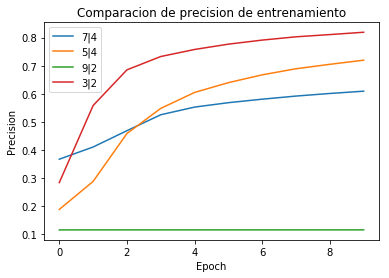

In [26]:
plt.plot(model_7x4_history.history['acc'])
plt.plot(model_5x4_history.history['acc'])
plt.plot(model_9x2_history.history['acc'])
plt.plot(model_3x2_history.history['acc'])
plt.title('Comparacion de precision de entrenamiento')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['7|4', '5|4', '9|2', '3|2'], loc='upper left')
plt.show()

El gráfico anterior da cuenta de como la precisión para el tercer caso (filtros de 9 x 9, *pool size* de 2 x 2) no mejora en ningún momento. Además, es importante notar que la precisión del primer caso (filtros de 7 x 7, *pool size* de 4 x 4) comienza en un valor más alto respecto a los dos casos restantes, pero su evolución se estanca rapidamente. Las arquitecturas del segundo y cuarto caso corresponden a los modelos que presentan mayores cambios de precisión a lo largo del proceso de entrenamiento.

También resulta interesante observar como evoluciona la función de pérdida en función de la cantidad de epochs llevadas a cabo, en cada caso. Notar que no se ha graficado la pérdida para el caso filtros de 9 x 9 y *pool size* de 2 x 2, puesto que el alto (y constante) valor de su función de pérdida no permitiría visualizar de forma apropiada las pérdidas de los demás modelos.

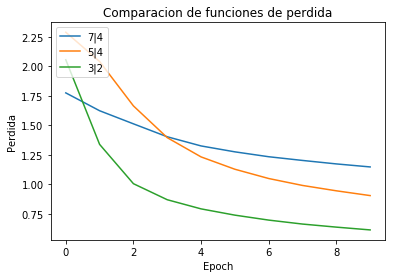

In [29]:
plt.plot(model_7x4_history.history['loss'])
plt.plot(model_5x4_history.history['loss'])
#plt.plot(model_9x2_history.history['loss'])
plt.plot(model_3x2_history.history['loss'])
plt.title('Comparacion de funciones de perdida')
plt.ylabel('Perdida')
plt.xlabel('Epoch')
plt.legend(['7|4', '5|4', '3|2'], loc='upper left')
plt.show()

El gráfico anterior muestra como las pérdidas de los modelos de filtros de 5 x 5, *pool size* de 4 x 4 y filtros de 3 x 3, *pool size* de 2 x 2 decaen más rapidamente respecto a la pérdida del modelo restante, siendo el caso '3|2' el más rápido en este sentido.

**2.4.5 Resumen**

En la tabla que se muestra a continuación, se resumen los resultados obtenidos en las sub-secciones anteriores.

Luego, se puede concluir que los mejores resultados, tanto en términos de precisión de prueba como tiempo de entrenamiento, se presentan en aquellos casos en el tamaño de los filtros convolucionales y el tamaño del *pool size* son similares entre sí. Por otra parte, al aumentar las diferencias de tamaños entre estas variables, los resultados empeoran.

**2.5 Modificando la cantidad de filtros**

En esta sección, se experimenta modificando la cantidad de filtros utilizados en las capas convolucionales, buscando conocer los efectos que estas medidas tienen tanto sobre el tiempo de entrenamiento como sobre el error de pruebas. Dados los resultados de la sección 2.4, el tamaño de los filtros de las capas convolucionales será de 3 x 3, mientras que el *pool size* será de 2 x 2 (modelo 2.4.4). Si bien esta arquitectura está levemente por debajo de la arquitectura original en términos de precisión, permitió reducir en alrededor de 1 hora y 10 minutos el tiempo de entrenamiento, por lo que se considera que representa un buen *trade-off* entre precisión y tiempo de entrenamiento.

**2.5.1 Primer caso: Disminuyendo la cantidad de filtros**

Se estudia el efecto de reducir la cantidad de filtros convolucionales a la mitad con respecto a la arquitectura original, esto es, 8 filtros en la primera y 256 en la segunda. 

In [14]:
model_8_256 = Sequential()
# Se añade primera capa convolucional, disminuyendo el tamaño de los filtros
model_8_256.add(Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=(n_rows, n_cols, n_channels)))
# Se agrega primera capa de reducción, reduciendo factor de pooling a 2 en cada dimensión
model_8_256.add(MaxPooling2D(pool_size=(2, 2)))
# Se introduce segunda capa convolucional, idéntica a la anterior
model_8_256.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# Se añade segunda capa de reducción, idéntica a la anterior
model_8_256.add(MaxPooling2D(pool_size=(2, 2)))
# Se agrega capa de tipo flatten
model_8_256.add(Flatten())
# Se introduce capa densa
model_8_256.add(Dense(20, activation='relu'))
# Se añade capa de salida
model_8_256.add(Dense(n_classes, activation='softmax'))

Luego, el modelo es entrenado.

In [15]:
model_8_256.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
model_8_256_history = model_8_256.fit(X_train_, Y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val_, Y_val))

Train on 58606 samples, validate on 14651 samples
Epoch 1/10
58606/58606 [==============================] - 392s - loss: 2.0016 - acc: 0.3020 - val_loss: 1.5673 - val_acc: 0.4676
Epoch 2/10
58606/58606 [==============================] - 396s - loss: 1.3085 - acc: 0.5729 - val_loss: 1.1587 - val_acc: 0.6270
Epoch 3/10
58606/58606 [==============================] - 394s - loss: 1.0607 - acc: 0.6636 - val_loss: 1.0052 - val_acc: 0.6924
Epoch 4/10
58606/58606 [==============================] - 396s - loss: 0.9450 - acc: 0.7070 - val_loss: 0.9363 - val_acc: 0.7023
Epoch 5/10
58606/58606 [==============================] - 404s - loss: 0.8674 - acc: 0.7334 - val_loss: 0.8572 - val_acc: 0.7451
Epoch 6/10
58606/58606 [==============================] - 408s - loss: 0.8177 - acc: 0.7510 - val_loss: 0.8172 - val_acc: 0.7580
Epoch 7/10
58606/58606 [==============================] - 412s - loss: 0.7747 - acc: 0.7652 - val_loss: 0.7798 - val_acc: 0.7711
Epoch 8/10
58606/58606 [=======================

Estando el modelo ya entrenado, se evalúa su rendimiento sobre el conjunto de pruebas.

In [16]:
model_8_256_scores = model_8_256.evaluate(X_test_, Y_test)
print 'Precision sobre conjunto de pruebas:', model_8_256_scores[1] * 100, '%'
model_8_256.save('model_8_256.h5')

26016/26032 [============================>.] - ETA: 0sPrecision sobre conjunto de pruebas: 79.9055009219 %


Se observa que la precisión obtenida sobre el conjunto de prueba es de un 79,91%, siendo menor a la precisión obtenida por la arquitectura original, aunque bastante cercana a la del modelo 2.4.4 (mismos tamaños de filtros y *pool size*, pero utilizando 16 y 512 filtros en la primera y segunda capa convolucional, respectivamente). Sin embargo, el tiempo total de entrenamiento fue de 3735 [s], superior a los 2890 [s] de este último.

**2.5.2 Segundo Caso: Aumentando la cantidad de filtros**

Se analiza el efecto de duplicar la cantidad de filtros usados en las capas convolucionales, es decir, se utilizan 32 filtros, en vez de 16 en la primera, y 1024 en la segunda, en vez de 512.

In [17]:
model_32_1024 = Sequential()
# Se añade primera capa convolucional, manteniendo constante el tamaño de los filtros
model_32_1024.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(n_rows, n_cols, n_channels)))
# Se agrega primera capa de reducción, reduciendo factor de pooling a 2 en cada dimensión
model_32_1024.add(MaxPooling2D(pool_size=(2, 2)))
# Se introduce segunda capa convolucional, idéntica a la anterior, reduciendo el tamaño de los filtros en dos unidades
model_32_1024.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
# Se añade segunda capa de reducción, idéntica a la anterior
model_32_1024.add(MaxPooling2D(pool_size=(2, 2)))
# Se agrega capa de tipo flatten
model_32_1024.add(Flatten())
# Se introduce capa densa
model_32_1024.add(Dense(20, activation='relu'))
# Se añade capa de salida
model_32_1024.add(Dense(n_classes, activation='softmax'))

Definido el modelo, este es entrenado.

In [18]:
model_32_1024.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
model_32_1024_history = model_32_1024.fit(X_train_, Y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val_, Y_val))

Train on 58606 samples, validate on 14651 samples
Epoch 1/10
58606/58606 [==============================] - 1092s - loss: 2.3488 - acc: 0.1797 - val_loss: 2.2597 - val_acc: 0.1875
Epoch 2/10
58606/58606 [==============================] - 1089s - loss: 2.2538 - acc: 0.1896 - val_loss: 2.2492 - val_acc: 0.1875
Epoch 3/10
58606/58606 [==============================] - 1090s - loss: 2.2464 - acc: 0.1896 - val_loss: 2.2441 - val_acc: 0.1875
Epoch 4/10
58606/58606 [==============================] - 1090s - loss: 2.2426 - acc: 0.1896 - val_loss: 2.2413 - val_acc: 0.1875
Epoch 5/10
58606/58606 [==============================] - 1090s - loss: 2.2403 - acc: 0.1896 - val_loss: 2.2396 - val_acc: 0.1875
Epoch 6/10
58606/58606 [==============================] - 1090s - loss: 2.2389 - acc: 0.1896 - val_loss: 2.2386 - val_acc: 0.1875
Epoch 7/10
58606/58606 [==============================] - 1090s - loss: 2.2381 - acc: 0.1896 - val_loss: 2.2379 - val_acc: 0.1875
Epoch 8/10
58606/58606 [================

A continuación, se evalúa el modelo sobre el conjunto de pruebas.

In [19]:
model_32_1024_scores = model_32_1024.evaluate(X_test_, Y_test)
print 'Precision sobre conjunto de pruebas:', model_32_1024_scores[1] * 100, '%'
model_32_1024.save('model_32_1024.h5')

26032/26032 [==============================] - 76s    
Precision sobre conjunto de pruebas: 19.5874308543 %


El resultado anterior implica que la precisión de prueba conseguida es de un 19,59%, empeorando considerablemente respecto a todas las arquitecturas implementadas hasta ahora (excepto por el modelo 2.4.3). Peor aún, el tiempo total empleado para el entrenamiento es el más alto hasta ahora: 10901 [s].

**2.5.3 Tercer caso: Usando la misma cantidad de filtros**

Se estudia el efecto de utilizar la misma cantidad de filtros en ambas capas convolucionales. La cantidad de filtros a utilizar será de 32.

In [19]:
model_32_32 = Sequential()
# Se añade primera capa convolucional, con 32 filtros
model_32_32.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(n_rows, n_cols, n_channels)))
# Se agrega primera capa de reducción, reduciendo factor de pooling a 2 en cada dimensión
model_32_32.add(MaxPooling2D(pool_size=(2, 2)))
# Se introduce segunda capa convolucional, idéntica a la anterior
model_32_32.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# Se añade segunda capa de reducción, idéntica a la anterior
model_32_32.add(MaxPooling2D(pool_size=(2, 2)))
# Se agrega capa de tipo flatten
model_32_32.add(Flatten())
# Se introduce capa densa
model_32_32.add(Dense(20, activation='relu'))
# Se añade capa de salida
model_32_32.add(Dense(n_classes, activation='softmax'))

Se entrena el modelo definido.

In [20]:
model_32_32.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
model_32_32_history = model_32_32.fit(X_train_, Y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val_, Y_val))

Train on 58606 samples, validate on 14651 samples
Epoch 1/10
 7168/58606 [==>...........................] - ETA: 1127s - loss: 12.7259 - acc: 0.1828

KeyboardInterrupt: 

Por último, la arquitectura es evaluada sobre el conjunto de pruebas.

In [18]:
model_32_32_scores = model_32_32.evaluate(X_test_, Y_test)
print '\nPrecision sobre conjunto de pruebas:', model_32_32_scores[1] * 100, '%'
model_32_32.save('model_32_32.h5')

25760/26032 [============================>.] - ETA: 0sPrecision sobre conjunto de pruebas: 68.9267055931 %


Luego, la precisión obtenida sobre el conjunto de prueba es de un ??,??%, mejorando/empeorando en comparación con la precisión obtenida por la arquitectura original, aunque bastante cercana a la del modelo 2.4.4 (mismos tamaños de filtros y *pool size*, pero utilizando 16 y 512 filtros en la primera y segunda capa convolucional, respectivamente). Sin embargo, el tiempo total de entrenamiento fue de ???? [s], superior a los ????[s] de este último.

De forma análoga a la sección 2.4, resulta interesante comparar la evolución del error de entrenamiento en función del número de epochs para los dos casos estudiados en esta sección.

In [15]:
plt.plot(model_8_256_history.history['acc'])
plt.plot(model_32_1024_history.history['acc'])
plt.plot(model_32_32_history.history['acc'])
plt.title('Comparacion de precision de entrenamiento')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['8|256', '32|1024', '32|32'], loc='upper left')
plt.show()

NameError: name 'model_8_256_history' is not defined

El gráfico construído muestra que ...

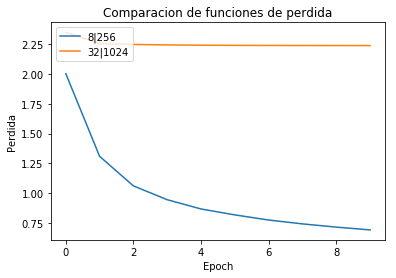

In [21]:
plt.plot(model_8_256_history.history['loss'])
plt.plot(model_32_1024_history.history['loss'])
plt.plot(model_32_32_history.history['loss'])
plt.title('Comparacion de funciones de perdida')
plt.ylabel('Perdida')
plt.xlabel('Epoch')
plt.legend(['8|256', '32|1024', '32|32'], loc='lower left')
plt.show()

** 2.5.3 Resumen **

En la siguiente tabla, se resumen los resultados conseguidos en las sub-secciones previas.

Así, ...

**2.6 Modificando la red**

En la siguiente sección, se desea introducir posibles mejoras en el rendimiento de la red sobre el conjunto de pruebas.

Teóricamente, se sabe que para construir un buen modelo, es necesario que la cantidad de ejemplos utilizados para su entrenamiento sea proporcional al número de parámetros que posee. En este contexto, tales condiciones no se cumplen, tomando en cuenta que el número de parámetros de las arquitecturas estudiadas es de un 1.000.000, mientras que la cantidad de ejemplos usados para el entrenamiento es de alredor de 60.000. Sin embargo, el aumentar significativamente el volumen de dichos ejemplos puede llevar a que el entrenamiento sea inviable si no se cuenta con los recursos computacionales apropiados. Luego, una alternativa que puede ayudar a remediar esta situación es regularizar el modelo por medio de *dropout*, esto es, desactivando un porcentaje determinado de las neuronas de las capas convolucionales en cada epoch.

También, se aumentará el número de neuronas en la capa densa, esperando que esto ayude a complementar el efecto de regularización. Dicho aumentó llevará a que la capa esté constituida por 100 neuronas.

En el siguiente código, se introducen las modificaciones señaladas. Para la primera capa convolucional, se utilizarán 16 filtros de dimensiones 5 x 5. Para la segunda, 512 filtros de tamaño 5 x 5. Por último, las capas de *max pooling* tendrán asociado un *pool size* de 2 x 2. El parámetro *dropout* será de un 25% para la primera capa convolucional y la capa densa, mientras que será de un 50% para la segunda capa convolucional.

In [35]:
modified_model = Sequential()
# Se añade primera capa convolucional
modified_model.add(Conv2D(8, (5, 5), padding='same', activation='relu', input_shape=(n_rows, n_cols, n_channels)))
# Se agrega primera capa de reducción
modified_model.add(MaxPooling2D(pool_size=(2, 2)))
# Se introduce dropout
modified_model.add(Dropout(0.25))
# Se introduce segunda capa convolucional
modified_model.add(Conv2D(256, (7, 7), padding='same', activation='relu'))
# Se añade segunda capa de reducción
modified_model.add(MaxPooling2D(pool_size=(2, 2)))
# Se introduce dropout
modified_model.add(Dropout(0.5))
# Se agrega capa de tipo flatten
modified_model.add(Flatten())
# Se introduce capa densa, aumentando a 100 la cantidad de neuronas
modified_model.add(Dense(100, activation='relu'))
# Se introduce dropout en capa densa
modified_model.add(Dropout(0.25))
# Se añade capa de salida
modified_model.add(Dense(n_classes, activation='softmax'))

En el siguiente esquema, se muestra en detalle los cambios experimentados por las dimensiones de un input determinado, junto con la cantidad de parámetros que este nuevo modelo posee.

In [36]:
# Se muestran nuevas características de modelo al agregar dropout y más neuronas a la capa densa
modified_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 8)         608       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 256)       100608    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 16384)             0         
__________

Se puede ver que ahora ...

En este punto, también resulta interesante entrenar el modelo utilizando otro método de optimización. En la literatura se ha señalado que adagrad, método de entrenamiento ocupado hasta ahora en todos los modelos implementados, puede llevar a que la tasa de aprendizaje decrezca muy rápido, impidiendo que la arquitectura que está siendo entrenada pueda aprender más. Debido a esto, el método de optimización será reemplazado por Adam, que adapta dicha tasa de forma menos "agresiva".   

In [37]:
# Se modifica método de entrenamiento usado hasta ahora: adam, en vez de adagrad
modified_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modified_model_history = modified_model.fit(X_train_, Y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val_, Y_val))

Train on 58606 samples, validate on 14651 samples
Epoch 1/10
58606/58606 [==============================] - 347s - loss: 2.0102 - acc: 0.2895 - val_loss: 1.5074 - val_acc: 0.5248
Epoch 2/10
58606/58606 [==============================] - 346s - loss: 1.2411 - acc: 0.5911 - val_loss: 0.9126 - val_acc: 0.7266
Epoch 3/10
58606/58606 [==============================] - 348s - loss: 0.9748 - acc: 0.6896 - val_loss: 0.7465 - val_acc: 0.7786
Epoch 4/10
58606/58606 [==============================] - 347s - loss: 0.8464 - acc: 0.7296 - val_loss: 0.6427 - val_acc: 0.8093
Epoch 5/10
58606/58606 [==============================] - 351s - loss: 0.7702 - acc: 0.7556 - val_loss: 0.5881 - val_acc: 0.8247
Epoch 6/10
58606/58606 [==============================] - 348s - loss: 0.7210 - acc: 0.7716 - val_loss: 0.5601 - val_acc: 0.8294
Epoch 7/10
58606/58606 [==============================] - 347s - loss: 0.6787 - acc: 0.7853 - val_loss: 0.5388 - val_acc: 0.8404
Epoch 8/10
58606/58606 [=======================

Luego, se evalúa el modelo sobre el conjunto de pruebas.

In [38]:
modified_model_scores = modified_model.evaluate(X_test_, Y_test)
print '\nPrecision sobre conjunto de pruebas:', modified_model_scores[1] * 100, '%'
modified_model.save('modified_model.h5')

26032/26032 [==============================] - 28s    

Precision sobre conjunto de pruebas: 85.1682544561 %


Con esto, se aprecia que la precisión de prueba que se obtiene es de un ??,?%, mejorando/empeorando en comparación con la  arquitectura original. Así (no) tiene sentido introducir las modificaciones que se describieron en los párrafos previos.

Para complementar el análisis llevado a cabo, se grafica la precisión y la función de pérdida en base al número de epochs.

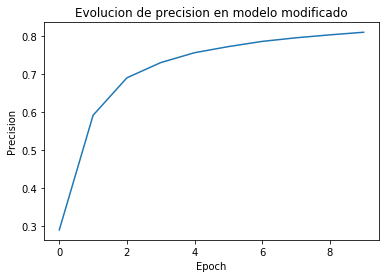

In [39]:
# Se grafica precisión
plt.plot(modified_model_history.history['acc'])
plt.title('Evolucion de precision en modelo modificado')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.show()

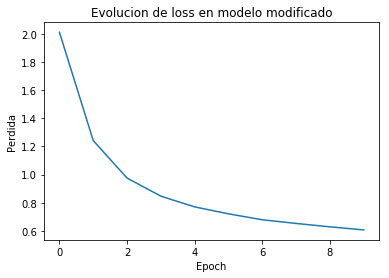

In [40]:
# Se grafica función de pérdida
plt.plot(modified_model_history.history['loss'])
plt.title('Evolucion de loss en modelo modificado')
plt.ylabel('Perdida')
plt.xlabel('Epoch')
plt.show()

**2.7 Visualización de pesos y efecto de filtros en primera capa convolucional**

En esta sección, se visualizan los pesos asociados a la primera capa convolucional del modelo definido en la sección 2.6. Se ha escogido dicho modelo dado a que fue el que logró obtener la mejor precisión sobre el conjunto de pruebas en comparación con los modelos previamente implementados.  

In [41]:
# Se obtienen pesos de primera capa convolucional del modelo 2.6
weights = modified_model.layers[0].get_weights()

A continuación, se obtiene tanto la cantidad de filtros utilizados como las dimensiones de la matriz de pesos de cada uno de ellos.

In [42]:
# Se obtiene el número de filtros y las dimensiones de la matriz de pesos
weights[0].shape

(5, 5, 3, 8)

Luego, la primera capa convolucional posee ?? filtros y las dimensiones de la matriz de pesos asociada a cada filtro posee dimensiones ? x ?, las que son utilizadas en cada uno de los ? canales del input recibido.

A modo de ejemplo, se muestra matriz de pesos del primer filtro de la capa. Notar que existe una matriz diferente por cada uno de los canales del input recibido.

In [43]:
# Se muestra matriz de pesos de primer filtro de la capa convolucional
weights[0].T[0]

array([[[ 0.02460662,  0.002521  ,  0.03103154, -0.01076862, -0.09692689],
        [-0.01360438, -0.0093404 , -0.14861253,  0.04381747,  0.10791935],
        [ 0.21493521, -0.32411826, -0.06459016,  0.03649415,  0.06145758],
        [-0.03915951, -0.01997727,  0.22151437, -0.08806448,  0.10040671],
        [-0.10130008, -0.07530107,  0.05114584,  0.04759633, -0.08441094]],

       [[ 0.05535317,  0.02087457, -0.14923923, -0.09985904, -0.00133368],
        [ 0.16493638,  0.12882064, -0.06952551, -0.04454484, -0.0792475 ],
        [ 0.01658586,  0.01102925, -0.16960846,  0.05239424,  0.03541715],
        [-0.06977211, -0.2691015 ,  0.03039802,  0.0598393 , -0.05879792],
        [-0.09498933, -0.04739706,  0.22397619, -0.14917965,  0.06912799]],

       [[ 0.11159866,  0.14566875, -0.01728983, -0.03692164, -0.01451333],
        [ 0.11055676,  0.03872261, -0.16822259,  0.09621096,  0.12314675],
        [ 0.2381788 , -0.17388473, -0.24247408,  0.18085203, -0.09607621],
        [ 0.11183203,

Por otra parte, también interesa conocer el efecto que tienen los filtros de la capa sobre una imágen determinada. Para ello, primero se escoge de forma aleatoria una imágen del conjunto de entrenamiento y se muestra.

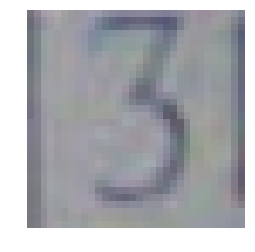

In [57]:
# Se escoge imágen de conjunto de entrenamiento

random.seed(11)
image = random.choice(X_train).reshape(n_channels, n_rows, n_cols).transpose(2, 1, 0)
plt.figure()
plt.imshow(image)
plt.axis('off')
plt.show()

En las siguientes figuras, se muestra el resultado de aplicar cada uno de los filtros de la primera capa convolucional sobre la imágen que acaba de ser mostrada. Cada uno de estos "resultados" es denominado *feature map* en la teoría y permite advertir las características que el filtro está aprendiendo a partir de la imágen.

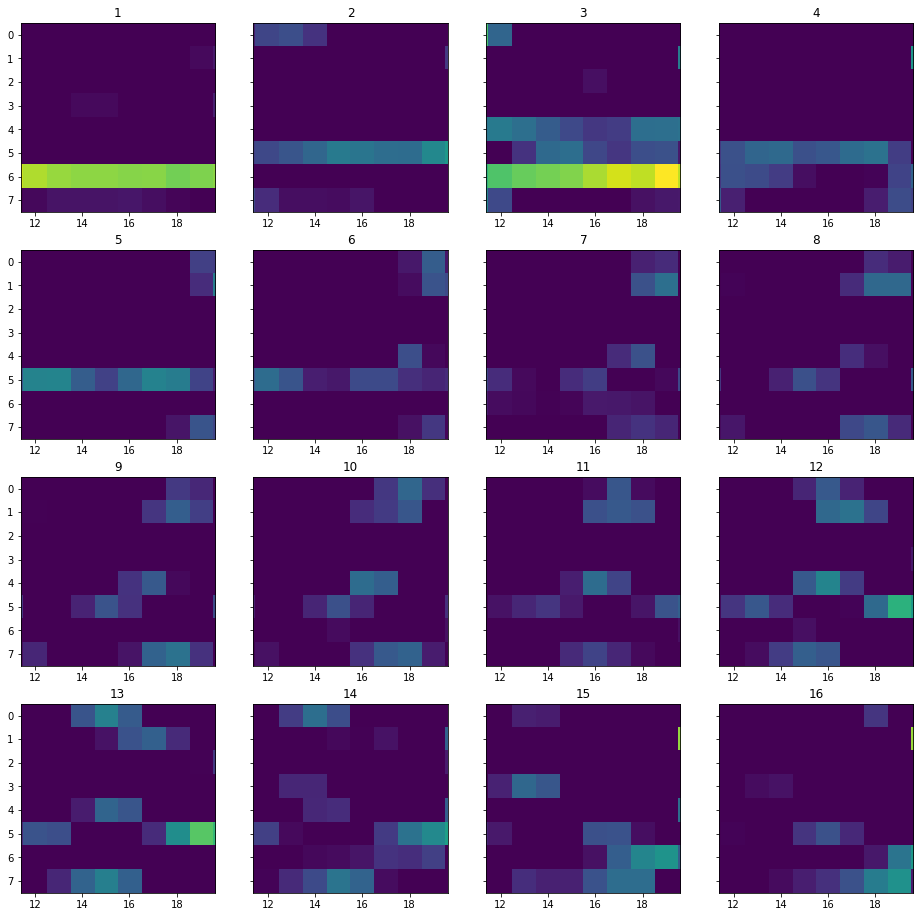

In [59]:
# Se obtiene feature map de cada filtro
filters_output_function = backend.function([modified_model.layers[0].input], [modified_model.layers[0].output])
filters_output = filters_output_function([np.array([image])])[0]

# Se muestra feature map de cada filtro
filters = filters_output[0]
f, ax = plt.subplots(4, 4, sharey=True, figsize=(16, 16))
for i in range(4):
    for j in range(4):
        filter_number = 4 * i + j + 1
        ax[i][j].set_title(filter_number)
        ax[i][j].imshow(np.transpose(filters[filter_number - 1]))
plt.show()

De esta manera, se aprecia que ...

**2.8 ¿Tiende la red a confudir ciertos dígitos?**

Culminando el análisis de este problema, se busca determinar los pares de dígitos que la red tiende a confudir. Para ello, se procede a computar la matriz de confusión del modelo escogido. De esta forma, se tiene que el elemento ij de esta matriz corresponde a la cantidad de imágenes cuya clase real es i, pero el modelo predijo j como su clase.

In [82]:
# Se crea lista con la clase real de cada imágen perteneciente al conjunto de prueba
real_values = [y[0] for y in y_test]
# Se crea lista con la clase predicha para cada imágen por el modelo considerado
predicted_values = list(np.argmax(modified_model.predict(X_test_), axis=1))

# A partir de las listas anteriores, se computa la matriz de confusión del modelo
confusion_matrix(real_values, predicted_values)

array([[4730,   56,   54,   82,   11,   30,   48,   32,   10,   46],
       [  45, 3775,   77,   56,   33,   27,   23,   61,   46,    6],
       [  76,   66, 2348,   33,   86,   13,   16,   87,  144,   13],
       [  81,   40,   55, 2264,    8,   23,    7,   19,   20,    6],
       [  27,   24,  195,   23, 1911,   62,    8,   90,   35,    9],
       [  35,   20,   32,   89,   91, 1531,    5,  139,    8,   27],
       [ 129,  127,   55,    7,   25,    4, 1636,    9,   19,    8],
       [  31,   27,   64,   39,   36,   74,    2, 1324,   42,   21],
       [  36,   79,   45,   14,   19,   15,    7,   52, 1268,   60],
       [  27,   48,   38,   10,   23,   61,   13,   73,   67, 1384]])

Observando la matriz de confusión, se tiene que ...